#**Deep Learning Homework 4: *Recurrent Neural Networks & Transformer***
### MSc Computer Science, Data Science, Cybersecurity @UNIPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti, Prof. Nicolò Navarin and Dr. Luca Pasa
---
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. We will use the IMDB dataset---it contains the text of some reviews and the sentiment given by their authors (either positive or negative). The input to the RNN is the sequence of words that compose a review, so the learning task consists in predicting the overall sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will solve the same classification problem with a Transformer, in order to have a closer look at its internal functioning.

---
##**Important Instructions for Submissions:**

Generally, in the homeworks, you will be either required to complete a part of Python code or to answer questions in text cells. Code and text cells where you are expected to write your answers have been marked by `%STARTCODE` and `%ENDCODE` or `%STARTEXT` and `%ENDTEXT` tags, respectively. Note that you should never change, move or remove these two tags, otherwise your answers will be __not__ valid. As you will see in this notebook, each cell that includes a `[TO COMPLETE]` part has been put between these placeholders. 

#Requirements

In [1]:
!pip3 install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Imports

In [2]:
import torch
from torch import nn
from torch.nn import Embedding, RNN, LSTM, GRU, Linear, Transformer
import torch.nn.functional as F
from torchinfo import summary
from torchtext.datasets import IMDB
from torch.utils.data import DataLoader, Dataset, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision.transforms import Lambda
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
rng = np.random.default_rng(seed=4242)

#Data Loading and Preprocessing

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). As usual, for speed and efficiency, we will use only a subset of the dataset. Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. We load the data from the PyTorch database and then split the data into train, validation and test set. 

In [55]:
train, test = IMDB(root="dataset", split=('train', 'test'))
Tr, Ts = list(train), list(test)
rng.shuffle(Tr)
rng.shuffle(Ts)
len_train, len_val, len_test = 25000, 12500, 12500 # Whole data
train_data, val_data, test_data = Tr[:len_train], Ts[:len_val], Ts[len_val:len_val+len_test]

In [56]:
len(train_data), len(val_data), len(test_data)

(25000, 12500, 12500)

In [57]:
idx = 10
label_samp, text_samp = train_data[idx]
print(f"text: {text_samp}")
print(f"label: {label_samp}")

text: When I first heard about the title, I thought of 'The Simpsons', just like so many other reviewers, but when I saw the cast, I was completely stunned, that so many great character-actors would actually be in this! First of all, we have Christopher Walken (Deer Hunter, Pulp Fiction), who plays the title character, McBain. He is rescued from a Vietnam POW-camp by some of his buddies, one of which is Santos (Chick Vennera, Yanks), who splits a HUNDRED DOLLAR BILL with McBain (Vietnam soldiers are loaded with cash apparently), and tells him that he can re-do the favor to him, if he ever gets into trouble.<br /><br />Then, 18 years later, Santos and his sister Christina (Maria Conchita Alonso, The Running Man, Predator 2) join the rebels in Colombia trying to get rid of their evil dictator, El Presidente (Victor Argo, Taxi Driver, King of New York), and when Santos fails the mission, Christina goes to McBain for help.<br /><br />McBain then asks his good ol' Vietnam buddies to help hi

Let's check the dataset statistics.

In [58]:
datasets = {'train':train_data, 'val':val_data, 'test':test_data}
for key in datasets:
  label_dist = {}
  dataset = datasets[key]
  for lb, txt in dataset:
    if lb not in label_dist:
      label_dist.setdefault(lb, 1)
    else:
      label_dist[lb] += 1
  print(f"{key}:")
  print(label_dist)


train:
{2: 12500, 1: 12500}
val:
{2: 6228, 1: 6272}
test:
{2: 6272, 1: 6228}


In [59]:
tokenizer = get_tokenizer('basic_english')

def create_tokens(dataset):
  for sample in dataset:
    yield tokenizer(sample[1])

vocab = build_vocab_from_iterator(create_tokens(train_data), specials=["<oov>", "<sos>"], max_tokens=10000)
vocab.set_default_index(vocab["<oov>"])
print(f"Our vocabulary is made of {len(vocab)} tokens-index pairs.")

Our vocabulary is made of 10000 tokens-index pairs.


In [60]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [61]:
print(vocab.get_itos())  # top 10000 freq words (including special chars)

['<oov>', '<sos>', 'the', '.', ',', 'and', 'a', 'of', 'to', "'", 'is', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', ')', '(', 'you', 't', 'on', 'not', 'he', 'are', 'his', 'have', 'be', 'one', '!', 'all', 'at', 'they', 'by', 'an', 'who', 'from', 'so', 'like', 'there', 'her', 'or', 'just', 'about', 'if', 'has', 'out', 'what', '?', 'some', 'good', 'can', 'more', 'when', 'she', 'very', 'even', 'my', 'no', 'up', 'would', 'time', 'which', 'only', 'story', 'really', 'their', 'see', 'had', 'we', 'were', 'me', 'than', 'well', 'much', '-', 'get', 'been', 'people', 'will', 'also', 'other', 'bad', 'into', 'do', 'because', 'great', 'first', 'how', 'him', 'don', 'most', 'its', 'made', 'then', 'them', 'way', 'could', 'make', 'too', 'any', 'after', 'movies', 'think', 'characters', 'character', 'watch', 'films', 'two', 'many', 'seen', 'being', 'never', 'little', 'plot', 'acting', 'where', 'best', 'love', 'did', 'life', 'show', 'know', 'does', 'ever', 'here',

In [62]:
word_index = {k:v for (k, v) in enumerate(vocab.get_itos())}

In [63]:
def decode_review(word_ids):
    return " ".join([word_index.get(word_id, "<err>") for word_id in word_ids])

print(text_samp)
print("\n")
print(decode_review(text_pipeline(text_samp)))

When I first heard about the title, I thought of 'The Simpsons', just like so many other reviewers, but when I saw the cast, I was completely stunned, that so many great character-actors would actually be in this! First of all, we have Christopher Walken (Deer Hunter, Pulp Fiction), who plays the title character, McBain. He is rescued from a Vietnam POW-camp by some of his buddies, one of which is Santos (Chick Vennera, Yanks), who splits a HUNDRED DOLLAR BILL with McBain (Vietnam soldiers are loaded with cash apparently), and tells him that he can re-do the favor to him, if he ever gets into trouble.<br /><br />Then, 18 years later, Santos and his sister Christina (Maria Conchita Alonso, The Running Man, Predator 2) join the rebels in Colombia trying to get rid of their evil dictator, El Presidente (Victor Argo, Taxi Driver, King of New York), and when Santos fails the mission, Christina goes to McBain for help.<br /><br />McBain then asks his good ol' Vietnam buddies to help him. Fir

To keep the length of the all the input sequences same, we define the padding function. All the sentence less than the lenght of 500 will be padded with zeros and greater than 500 will be truncated. Notice that we will pad and truncate sequences right-wise, so that processing the sequences, the final hidden states of the recurrent networks will correspond to the final words of each sequence in the batch.



In [64]:
def sent_padding(sent_vec, maxlen):
  sent_vec = torch.tensor(sent_vec)
  maxlen -= len(sent_vec)
  return F.pad(sent_vec, (maxlen, 0))


print(sent_padding([1,2,3], maxlen=6))
print(sent_padding([1,2,3,4,5,6,7,8,9], maxlen=6))

tensor([0, 0, 0, 1, 2, 3])
tensor([4, 5, 6, 7, 8, 9])


In [65]:
seq_len = 500
sent_padding(text_pipeline(text_samp), maxlen=seq_len)

tensor([ 699,   96,   15,   30,   58,    0,    2, 2043,    8,   96,    4,   51,
          30,  131,  216,   90, 1093,    3,  101,    4, 3406,  161,  306,    4,
           0,    5,   32,  765, 6333,   25, 2715,    0,    0,    4,    2,  632,
         135,    4, 7397,  292,   24, 2824,    2, 7594,   12,    0,  270,    8,
          83, 3710,    7,   73,  450, 8016,    4, 5586,    0,   25, 2145,    0,
           4, 4717, 2532,    4,  615,    7,  167,  749,   24,    4,    5,   60,
           0,  965,    2, 1965,    4, 6333,  271,    8,    0,   19,  339,    3,
           0,  101, 1602,   32,   57, 6219,    9, 2675, 3925,    8,  339,   96,
           3,   94,   46,    9,   16,    2, 6011, 1250,  335,  234,    4,    0,
           4,  259,   40,  325, 5180,    9,   16, 1174,  567,    4,   42,   17,
          87,   12,  173,  567,    0,    9,  931,   21,    4,    2,    0,    4,
         123,    2,    0,    9,   16,  156,  410,   87,   17,    0,    4, 5257,
          55,   13,  110,   29,    3,   

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [67]:
class CustomDataset(Dataset):
  
  def __init__(self, dataset, seq_len=seq_len):
    super().__init__()
    self.dataset = dataset
    self.seq_len = seq_len
  
  def __len__(self):
    return len(self.dataset) 
  
  def __getitem__(self, idx):
    label, text = self.dataset[idx]
    label = label_pipeline(label)
    txt_rep = sent_padding(text_pipeline(text), maxlen=self.seq_len)
    label, txt_rep = torch.tensor(label, dtype=torch.float32), torch.tensor(txt_rep, dtype=torch.long)
    return label.to(device), txt_rep.to(device)

In [68]:
train_dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)
test_dataset = CustomDataset(test_data)

In [69]:
batch_size=256
dataloader_training = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(val_dataset, batch_size=batch_size)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size)

#Model Definition

Let's define the model: 
- The first layer is an Embedding layer, with input_dim=vocab_dim and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) 
- The output layer 

### Model Comparison

In order to perform a fair comparison of the models RNN, LSTM and GRU make sure they use more or less the same number of parameters.

In the next cell, we define our simple RNN used for binary classification. The class has two main methods, the constructor (`init()`) and the `forward()` method.

In the constructor, the input parameters are used to define the layers and hyperparameters of the RNN. The layers that are defined include an embedding layer (`self.embedding`), a recurrent layer (`self.rnn`), and a linear layer (`self.linear`). The constructor also sets up various parameters such as the embedding input size, the embedding output size, the hidden size, the number of layers, the batch size, the RNN type, and whether or not the RNN is bidirectional.

The `forward()` method takes a batch of input data (`x`) and applies the layers defined in the constructor in a specific sequence. First, the input is passed through the embedding layer to create embeddings of the input tokens. These embeddings are then permuted to be of the correct shape for the RNN layer, which expects inputs of the form (`seq_len, batch_size, H_in`). The RNN layer is then applied to these embeddings, producing both the RNN output (`rnn_out`) and the last hidden state (`self.last_hidden`). Finally, the output of the RNN is passed through a linear layer and flattened to produce the final output of the network, which is a sigmoid activation function applied to a tensor of shape (`batch_size`). This output is then returned.

In [37]:
class My_RNN(nn.Module):
  def __init__(self, vocab_length, emb_dim, hidden_size, num_layers,
               batch_size, RNN_type, bidirectional, device=device):
    super().__init__()
    self.emb_in_dim = vocab_length  # 10000
    self.emb_out_dim = emb_dim  # 10
    self.hidden_size = hidden_size 
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.batch_size = batch_size
    self.RNN_type = RNN_type
    self.target_size = 1  # binary classification
    self.device = device
    self.D = 2 if self.bidirectional else 1  # enable/disable bidirectional
    
    valid_types = {'Simple RNN':RNN, 'LSTM':LSTM, 'GRU':GRU}
    assert self.RNN_type in valid_types.keys(), f'You must choose one of {valid_types.keys()} types'
    
    self.embedding = Embedding(self.emb_in_dim, self.emb_out_dim) 
    
    chosen_rnn = valid_types[self.RNN_type]
    self.rnn = chosen_rnn(input_size=self.emb_out_dim, hidden_size=self.hidden_size,
                          num_layers=self.num_layers, bidirectional = self.bidirectional)
    
    self.linear = Linear(self.D*self.hidden_size, self.target_size)

  def forward(self, x):
    #x: (batch_size, 500)
    self.embeds = self.embedding(x)
    #embeds: (batch_size, 500, 10)
    #But rnn receives inputs of: (500, batch_size, 10) (seq_len, batch_size, H_in)
    self.embeds = self.embeds.permute(1, 0, 2)
    #embeds: (500, batch_size, 10) -> Now the shape is correct
    rnn_out, self.last_hidden = self.rnn(self.embeds)
    #rnn_out: (500, 256, 2*5:10) -> (seq_len, batch_size, D*hidden_size)
    #h_n: (1, 256, hidden_size) -> (D*num_layers, batch_size, hidden_size)
    output = self.linear(rnn_out[-1, :, :])
    #output: (256, 1) -> (batch_size, target_size)
    output = output.flatten()
    #output: (256) -> (batch_size)
    return F.sigmoid(output)

### [TO COMPLETE] Simple RNN

We define a RNN model and evaluate its performance. Your task is to choose the right loss function and motivate your choice. 



`%STARTEXT`

ANSWER: I decided to use Binary Cross-Entropy Loss, since we are dealing with a binary classification problem. This is usually the first to be considered since it is equivalent to fitting the model using maximum likelihood estimation.

`%ENDTEXT`

`%STARTCODE`

In [38]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'Simple RNN' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False

EPOCHS = 10
lr = 1e-3

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion =nn.BCELoss() #[TO COMPLETE]     
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [39]:
print(summary(model))

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─RNN: 1-2                               1,408
├─Linear: 1-3                            33
Total params: 101,441
Trainable params: 101,441
Non-trainable params: 0


`%ENDCODE`

Now we can train our model. Try to grasp how a training loop is defined in PyTorch and what each line does!

In [40]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()
      
      labels_form_logits = lambda x: 0. if x < 0.5 else 1.
      logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
      total_acc_train += (logits == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
            total_acc_val += (logits == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [41]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 53.24%, Loss: 0.69028193 ---------------- Val_Acc: 54.22%, Val_Loss: 0.68685609
epoch: 2 -> Accuracy: 57.07%, Loss: 0.67830324 ---------------- Val_Acc: 60.22%, Val_Loss: 0.66440618
epoch: 3 -> Accuracy: 60.08%, Loss: 0.66230136 ---------------- Val_Acc: 63.25%, Val_Loss: 0.64688450
epoch: 4 -> Accuracy: 63.70%, Loss: 0.64038670 ---------------- Val_Acc: 65.54%, Val_Loss: 0.63020408
epoch: 5 -> Accuracy: 66.52%, Loss: 0.61455625 ---------------- Val_Acc: 67.66%, Val_Loss: 0.60856318
epoch: 6 -> Accuracy: 67.95%, Loss: 0.60249698 ---------------- Val_Acc: 67.78%, Val_Loss: 0.60560596
epoch: 7 -> Accuracy: 70.12%, Loss: 0.58027226 ---------------- Val_Acc: 70.83%, Val_Loss: 0.58051175
epoch: 8 -> Accuracy: 71.06%, Loss: 0.57580525 ---------------- Val_Acc: 63.42%, Val_Loss: 0.63736421
epoch: 9 -> Accuracy: 71.55%, Loss: 0.56672019 ---------------- Val_Acc: 65.75%, Val_Loss: 0.62558109
epoch: 10 -> Accuracy: 71.08%, Loss: 0.56844735 ---------------- Val_Acc: 71.90%, 

It's time to plot the results...

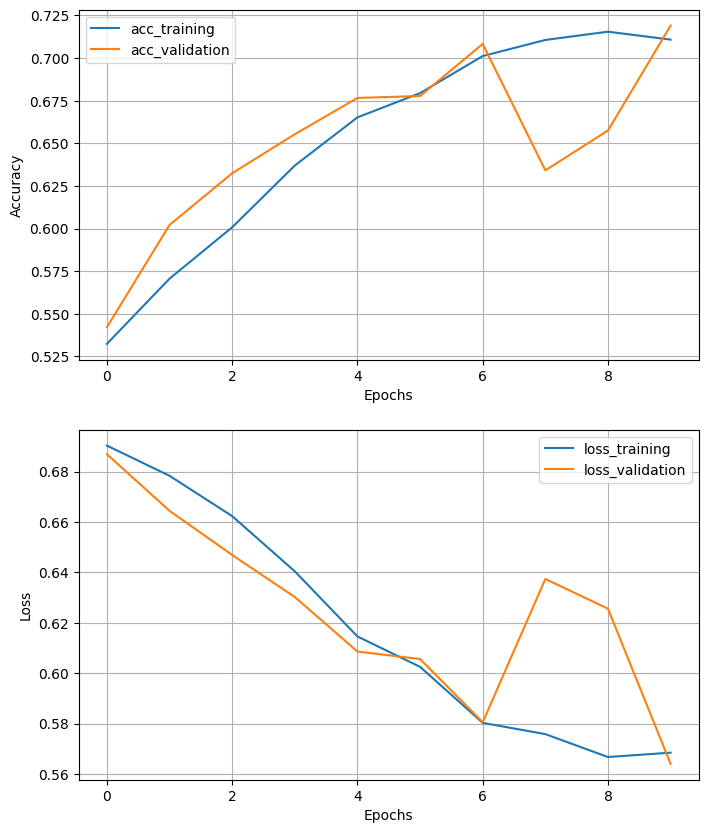

In [42]:
def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(EPOCHS), acc_tr, label='acc_training')
    plt.plot(range(EPOCHS), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(EPOCHS), loss_tr, label='loss_training')
    plt.plot(range(EPOCHS), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

...and see the performances on the test set:

In [43]:
def test(model, dataloader_test=dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (label, text) in enumerate(dataloader_test):
      pre_label = model(text)
      loss += criterion(pre_label, label)
      labels_form_pre_label = lambda x: 0. if x < 0.5 else 1.
      pre_label = torch.tensor(list(map(labels_form_pre_label, pre_label))).to(model.device)
      total_acc_test += (pre_label == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")


In [44]:
test(model)

Test Loss: 0.56688637 ---------- Test Accuracy: 71.2160%


We should achieve ~60% accuracy on test set. Lets see if we can improve further!

### [TO COMPLETE] LSTM

In this Exercise, you have to implement [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) model, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM layer. Print the model summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

`%STARTCODE`

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─LSTM: 1-2                              5,632
├─Linear: 1-3                            33
Total params: 105,665
Trainable params: 105,665
Non-trainable params: 0
epoch: 1 -> Accuracy: 52.66%, Loss: 0.69051141 ---------------- Val_Acc: 55.68%, Val_Loss: 0.68555719
epoch: 2 -> Accuracy: 58.51%, Loss: 0.67467141 ---------------- Val_Acc: 61.96%, Val_Loss: 0.66374922
epoch: 3 -> Accuracy: 63.90%, Loss: 0.64088720 ---------------- Val_Acc: 65.90%, Val_Loss: 0.62406611
epoch: 4 -> Accuracy: 63.38%, Loss: 0.65323395 ---------------- Val_Acc: 57.82%, Val_Loss: 0.67227781
epoch: 5 -> Accuracy: 59.64%, Loss: 0.66701722 ---------------- Val_Acc: 59.41%, Val_Loss: 0.66282535
epoch: 6 -> Accuracy: 62.75%, Loss: 0.64511448 ---------------- Val_Acc: 65.89%, Val_Loss: 0.63261521
epoch: 7 -> Accuracy: 69.31%, Loss: 0.59499830 ---------------- Val_Acc: 70.47%, Va

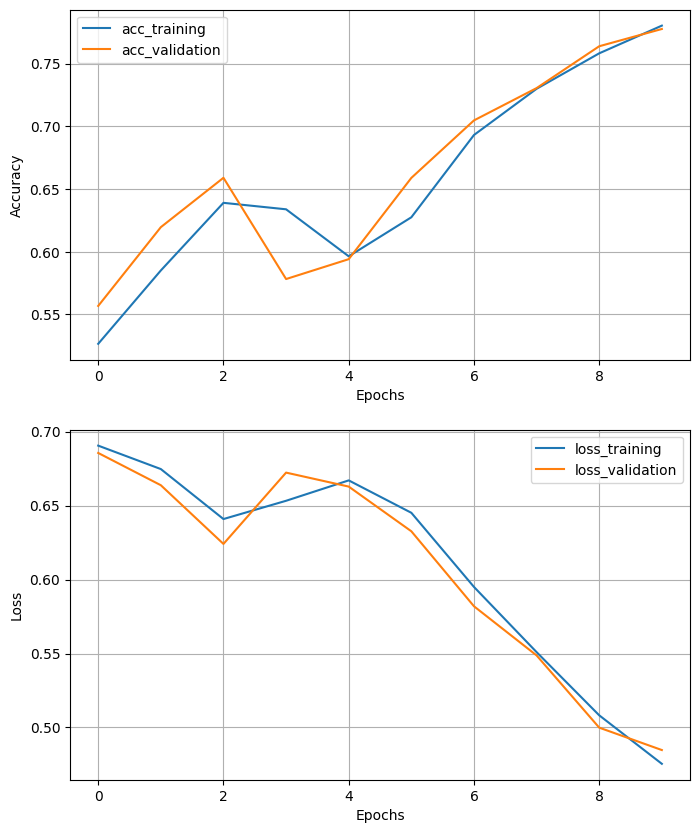

Test Loss: 0.49005273 ---------- Test Accuracy: 77.1280%


In [45]:
# [TO COMPLETE]
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'LSTM' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False

EPOCHS = 10
lr = 1e-3

lstm_model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)
print(summary(lstm_model))

criterion = nn.BCELoss()    
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(lstm_model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

test(lstm_model)

`%ENDCODE`

`%STARTEXT`

ANSWER: **TO COMPLETE**

**Number of Parameters**


The Embedding layer enables us to convert each word into a fixed length vector of defined size. This layer is between the input and the LSTM layer.

num_params= vocab_dim x output_dim = 10,000 x 10 = 100,000

If we choose in the RNN_type to have a RNN layer, we have:

num_params = (input_size + hidden_size + output_size) x (hidden_size) + bias
num_params = (10 + 32 + 1) x 32 + 32 = 1,408


If we have a LSTM layer:

 The LSTM layer is a recurrent layer that captures sequential dependencies in the data. For the number of parameters we have to consider also the number of gates that is 4(input gate, block input gate, forget gate and output gate). 

Since the rest of the architecture has remained invariant, the number of parameters is 4 times the number of parameters of the RNN layer:
num_params = 4 x 1,408 = 5,632

Linear layer: The linear layer in both simple RNN and LSTM models is responsible for mapping the output of the RNN or LSTM layer to a single output value. 

num_params = hidden_size x output_size + bias = 32 x 1 + 1 = 33

**Training Time**

* RNN = Training time in second: 138.505792078
* LSTM= Training time in second: 149.02296343299986

LSTMs usually take longer to train compared to simple RNNs. This is because LSTM networks have more complex internal operations and additional parameters, such as the memory cell and the gate mechanisms. 


**Performance discussion**

* RNN: Test Loss: 0.56688637 ---------- Test Accuracy: 71.2160%
* LSTM: Test Loss: 0.49005273 ---------- Test Accuracy: 77.1280%

As this example shows, LSTMs usually achieve higher accuracy compared to simple RNNs, especially for tasks that involve capturing long-term dependencies. Indeed, LSTMs are designed to overcome the vanishing gradient problem.


`%ENDTEXT`

### [TO COMPLETE] GRU

In this Exercise, you have to implement [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html) model, similar to the previous one that, instead of exploiting the RNN layer, use an GRU layer. Print the model summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

`%STARTCODE`

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─GRU: 1-2                               4,224
├─Linear: 1-3                            33
Total params: 104,257
Trainable params: 104,257
Non-trainable params: 0
epoch: 1 -> Accuracy: 52.08%, Loss: 0.69135308 ---------------- Val_Acc: 55.53%, Val_Loss: 0.68734407
epoch: 2 -> Accuracy: 58.86%, Loss: 0.66780472 ---------------- Val_Acc: 61.75%, Val_Loss: 0.65025783
epoch: 3 -> Accuracy: 67.40%, Loss: 0.60531652 ---------------- Val_Acc: 70.34%, Val_Loss: 0.57285142
epoch: 4 -> Accuracy: 73.61%, Loss: 0.53407282 ---------------- Val_Acc: 75.58%, Val_Loss: 0.50917125
epoch: 5 -> Accuracy: 78.25%, Loss: 0.47358730 ---------------- Val_Acc: 78.57%, Val_Loss: 0.46474829
epoch: 6 -> Accuracy: 80.92%, Loss: 0.42493621 ---------------- Val_Acc: 80.42%, Val_Loss: 0.42958921
epoch: 7 -> Accuracy: 83.70%, Loss: 0.38049245 ---------------- Val_Acc: 81.31%, Va

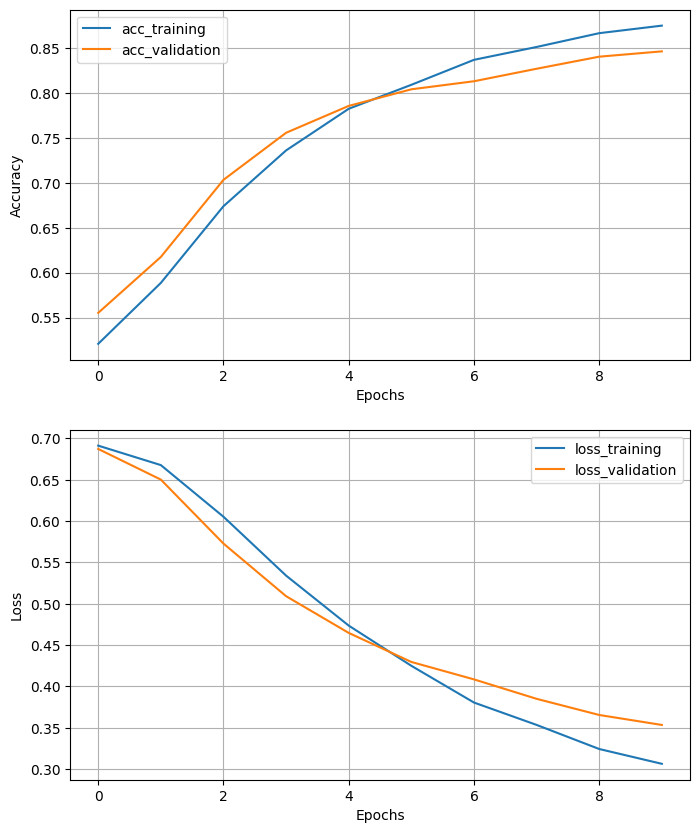

Test Loss: 0.36114055 ---------- Test Accuracy: 84.2720%


In [46]:
# [TO COMPLETE]
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'GRU' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False

EPOCHS = 10
lr = 1e-3

gru_model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)
print(summary(gru_model))

criterion = nn.BCELoss()    
optimizer = torch.optim.Adam(gru_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(gru_model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

test(gru_model)

`%ENDCODE`

`%STARTEXT`

ANSWER: **TO COMPLETE** 

**Performance discussion**

1.   RNN
  *   Total params: 101,441 (1,408 in the RNN layer)
  *   Test Loss: 0.56688637 ---------- Test Accuracy: 71.2160%
  *   Training time in second: 138.505792078
2.   LSTM
  *   Total params: 105,665 (5,632 in the LSTM layer)
  *   Test Loss: 0.49005273 ---------- Test Accuracy: 77.1280%
  *   Training time in second: 149.02296343299986
3.   GRU
  *   Total params: 104,257 (4,224 in the GRU layer)
  *   Test Loss: 0.36114055 ---------- Test Accuracy: 84.2720%
  *   Training time in second: 139.91651712699968


RNN, LSTM, and GRU have the same number of parameters in the Embedding and Linear layers. For the GRU layer the number of parameters is less than for LSTM but more than for RNN. LSTM and GRU models are both designed to address the limitations of simple RNNs in capturing long-term dependencies.Therefore, both LSTM and GRU models tend to achieve higher accuracy compared to simple RNN models.  Usually, is the LSTM model that provides a better accuracy but at the cost of longer training times. In the specific case of limited training data the GRU model tends to have a better performance because is less prone to overfitting and has a faster training time.


`%ENDTEXT`

#BiDirectional

Let's also have a look at the performances of a bidirectional LSTM instead of a simple LSTM. Try to understand what is the difference with respect to the previous model and use again the same loss you used before. This is just an extra model, so it will not be graded.


In [29]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'LSTM' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = True

EPOCHS = 15
lr = 3e-4

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = nn.BCELoss() # COMPLETE
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
summary(model)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─LSTM: 1-2                              11,264
├─Linear: 1-3                            65
Total params: 111,329
Trainable params: 111,329
Non-trainable params: 0

In [30]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 51.80%, Loss: 0.69213319 ---------------- Val_Acc: 53.60%, Val_Loss: 0.69055188
epoch: 2 -> Accuracy: 54.06%, Loss: 0.68963164 ---------------- Val_Acc: 54.59%, Val_Loss: 0.68850642
epoch: 3 -> Accuracy: 56.20%, Loss: 0.68580270 ---------------- Val_Acc: 56.67%, Val_Loss: 0.68032253
epoch: 4 -> Accuracy: 60.33%, Loss: 0.66262239 ---------------- Val_Acc: 62.90%, Val_Loss: 0.64811444
epoch: 5 -> Accuracy: 61.44%, Loss: 0.66121083 ---------------- Val_Acc: 52.72%, Val_Loss: 0.72333610
epoch: 6 -> Accuracy: 57.10%, Loss: 0.67975974 ---------------- Val_Acc: 60.76%, Val_Loss: 0.65991449
epoch: 7 -> Accuracy: 64.07%, Loss: 0.64505845 ---------------- Val_Acc: 64.65%, Val_Loss: 0.63937885
epoch: 8 -> Accuracy: 65.28%, Loss: 0.63231558 ---------------- Val_Acc: 65.81%, Val_Loss: 0.63136119
epoch: 9 -> Accuracy: 66.24%, Loss: 0.62412155 ---------------- Val_Acc: 66.00%, Val_Loss: 0.62109363
epoch: 10 -> Accuracy: 67.08%, Loss: 0.61301380 ---------------- Val_Acc: 66.61%, 

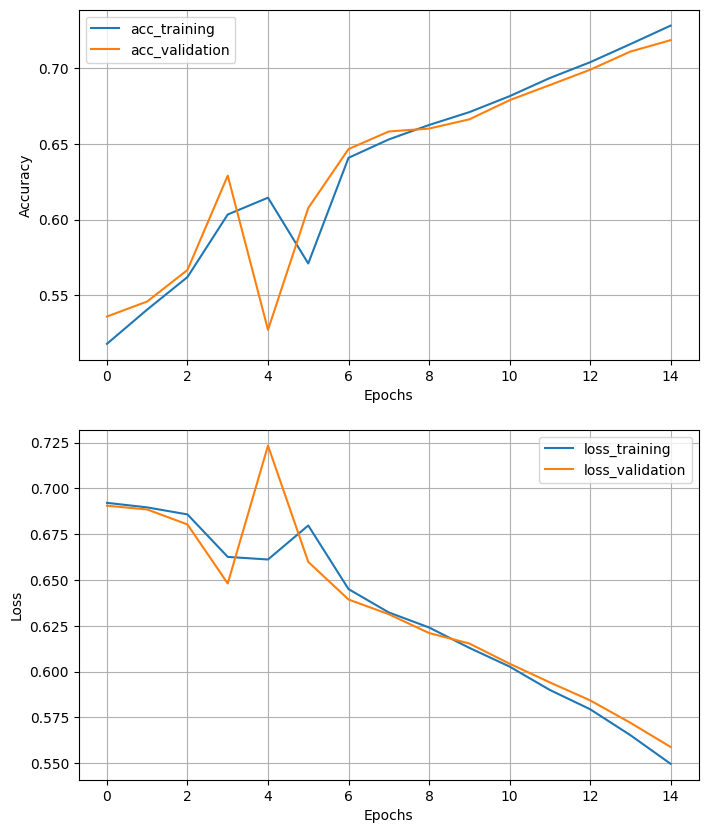

In [31]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [32]:
test(model)

Test Loss: 0.55693746 ---------- Test Accuracy: 72.2720%


# Explore relations between words

We will now quickly explore the properties of the embeddings learned by the model. Each embedding encodes the meaning of a word inferring it from the way it is used in the dataset. One possible way to explore the meaning encoded in the embeddings is check whether analogies that we make between concepts are reflected also in the embeddings as geometric properties. In particular, we will compute the difference between the embeddings of two related words, thus encoding their relation in a vector. Then, we will compute the same measure between a few couples of vectors and check if the couple which has the most similar measure corresponds to words that have the same kind of relation as the first ones. You can try different couples of words, and you may find out that sometimes the encoding of words meanings is the one we might expect - that's why carefully choosing the training data is very important!

In [73]:
def word_embedder(word):
  word_high_dim = sent_padding(text_pipeline(word), maxlen=seq_len).to(device)
  word_low_dim_embedded = model.embedding(word_high_dim)[-1]
  return word_low_dim_embedded

EMB_VOCAB = {}
for word in vocab.get_itos():
  EMB_VOCAB[word] =  word_embedder(word)

In [74]:
def cosine_similarity(u, v):
    return torch.dot(u,v) / (torch.sqrt(torch.sum(u * u)) * torch.sqrt(torch.sum(v * v)))

def word_matcher(ref1, ref2, tgt3, candidates, EMB_VOCAB):
  max_thr = -np.inf
  e_ref1, e_ref2, e_tgt3 = EMB_VOCAB[ref1], EMB_VOCAB[ref2], EMB_VOCAB[tgt3]
  for w in candidates:
    e_w = EMB_VOCAB[w]
    sim = cosine_similarity(e_ref2 - e_ref1, e_w - e_tgt3)
    if sim > max_thr:
      result = w
      max_thr = sim
  return result

w1, w2, w3 = 'man', 'woman', 'king'
w4_cand = ['soldier', 'queen', 'prophet']
w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

w1, w2, w3 = 'germany', 'berlin', 'italy'
w4_cand = ['spain', 'rome', 'germany', 'france']
w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

The relation between man -> woman is like the realtion between king -> prophet
The relation between germany -> berlin is like the realtion between italy -> france


### [TO COMPLETE] Transformer

Let's now use a [Transformer](https://arxiv.org/abs/1706.03762) to perform the same task considered in the previous exercise. 

The structure of the transformer is defined as follows:
*   A multi-head attention layer
*   Dropout operation (`dropout_att`)
*   Layer Normalization (`layernorm_att`)
*   A feedforward Neural Network, Sequential, and Dense layer
*   Dropout operation (`dropout_fnn`)
*   Layer Normalization (`layernorm_fnn`) that has in input the summation of the attention layer output and the feedforward NN output

Your task is to experiment with different hyperparameters values and try to find a configuration of the Transformer that can beat the RNNs. In the cell below, write a short comment on the impact of each hyperparameter on model performance according to your observations.

`%STARTEXT`

ANSWER: **[TO COMPLETE]**
Let's analyze the impact of each hyperparameter on model performance:

d_model: is the dimensionality of the embedding vectors, the number of expected features in the encoder inputs. Increasing the d_model can increase the model's capacity to capture complex patterns and so the performance. However, a higher d_model means more parameters and bigger computational time. I tried different values and the max for which I did not get the CUDA out of memory error was 16.

nhead: is the number of heads in the multihead attention mechanism. Increasing the number of attention heads allows the model to focus on different parts of the input sequence simultaneously, but this comes with a computational cost. The value of d_model should be divisible by the value of nhead, in order to ensure that the dimensions align properly during the multi-head attention mechanism. The value 2 was the highest I could choose with d_model= 16, avoiding the CUDA error. I tried also to decrease d_model and increase nhead (3,4) but I obtained a lower accuracy.

num_encoder_layers: is the number of layers in the encoder stack of the Transformer. It determines the depth of the encoder, affecting the model's capacity to capture complex patterns. Adding more layers increases the risk of overfitting, especially if the training set is small. The value of 2 was the highest feasible value to avoid an 'Out of Memory' error while still achieving relatively high accuracy. Decreasing d_model to enable a higher num_encoder_layers resulted in lower accuracy and increased vulnerability to overfitting.

num_decoder_layers: is the number of decoder layers in the Transformer. As for to the encoder layers, more decoder layers allows the model to capture more complex representations. The number of decoder layers is usually the same of the number of encoder layers, so I tried the same values.

To follow the model that I chose:
* d_model= 16
* nhead= 2                 
* num_encoder_layers= 2    
* num_decoder_layers=2

This was the model with the best performance(Test Accuracy: 85.0400%) that I was able to find avoiding the 'Out of Memory' error.

`%ENDTEXT`

In [21]:
new_seq_len = 200
train_dataset_trns = CustomDataset(train_data, seq_len=new_seq_len)
val_dataset_trns = CustomDataset(val_data, seq_len=new_seq_len)
test_dataset_trns = CustomDataset(test_data, seq_len=new_seq_len)

batch_size=256
dataloader_training_trns = DataLoader(train_dataset_trns, batch_size=batch_size, shuffle=True)
dataloader_validation_trns = DataLoader(val_dataset_trns, batch_size=batch_size)
dataloader_test_trns = DataLoader(test_dataset_trns, batch_size=batch_size)

In [22]:
class My_Transform(nn.Module):
  def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, layer_norm_eps, device=device):
    super().__init__()
    self.device = device

    self.emb_en = Embedding(num_embeddings=len(vocab), embedding_dim=d_model)
    self.emb_de = Embedding(num_embeddings=2, embedding_dim=d_model)
    #2: because of binary classification

    self.transformer = Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers,
                                   num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward,
                                   dropout=dropout, layer_norm_eps=layer_norm_eps)
    
    self.linear = Linear(d_model, 1)#1: because of binary classification

  def forward(self, x, y):

    #x: (batch_size, seq_len) -> (256, 200)
    #y: (batch_size) -> (256)

    y = torch.roll(y, shifts=1, dims=0) #right shifted

    self.embedded_src = self.emb_en(x)
    #self.embedded_src: (batch_size, seq_len, d_model) -> (256, 200, 5)

    '''
    Transformer requires src_dim and trg_dim of (S, N, E)
    (S, N, E) -> (Seq_len, Batch_size, Embed_dim) -> (seq_len, batch_size, d_model)
        - self.embedded_src must be permuted
        - self.embedded_trg must be reshaped accordingly
    Transformer will produce an output of dim (T, N, E)
    (T, N, E) -> (Target_len, Batch_size, Embed_dim) -> (1, batch_size, d_model)
    '''
    
    self.embedded_src = self.embedded_src.permute(1, 0, 2)
    #self.embedded_src: (seq_len, batch_size, d_model) -> (200, 256, 5)
    self.embedded_trg = self.emb_de(y.unsqueeze(0).long()) 
    #self.embedded_trg: (seq_len:target_len, batch_size, d_model) -> (1, 256, 5)

    trns_out = self.transformer(self.embedded_src, self.embedded_trg)
    #trns_out: (target_len, batch_size, d_model) -> (1, 256, 5)

    out = self.linear(trns_out)
    #out: (1, 256, 1)

    return F.sigmoid(out.squeeze()) #(batch_size) -> (256) : Like y

`%STARTCODE`

In [47]:
d_model= 16 #[TO COMPLETE]
nhead= 2 #[TO COMPLETE]                  
num_encoder_layers= 2 #[TO COMPLETE]     
num_decoder_layers=2 #[TO COMPLETE]     
dim_feedforward=128
dropout=0.1
layer_norm_eps=1e-5

EPOCHS = 10
lr = 1e-3

transformer = My_Transform(d_model, nhead, num_encoder_layers, num_decoder_layers,
                           dim_feedforward, dropout, layer_norm_eps).to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=lr)

summary(transformer)

Layer (type:depth-idx)                                                 Param #
My_Transform                                                           --
├─Embedding: 1-1                                                       160,000
├─Embedding: 1-2                                                       32
├─Transformer: 1-3                                                     --
│    └─TransformerEncoder: 2-1                                         --
│    │    └─ModuleList: 3-1                                            10,784
│    │    └─LayerNorm: 3-2                                             32
│    └─TransformerDecoder: 2-2                                         --
│    │    └─ModuleList: 3-3                                            13,024
│    │    └─LayerNorm: 3-4                                             32
├─Linear: 1-4                                                          17
Total params: 183,921
Trainable params: 183,921
Non-trainable params: 0

`%ENDCODE`

In [48]:
def train_trns(model, optimizer, dataloader_train, dataloader_val, epochs=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):

      optimizer.zero_grad()
      logits = model(text, label)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()
      
      labels_form_logits = lambda x: 0. if x < 0.5 else 1.
      logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
      total_acc_train += (logits == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):

            logits = model(text, label)
            loss = criterion(logits, label)
            total_loss_val += loss
            logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
            total_acc_val += (logits == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [49]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train_trns(transformer, optimizer, dataloader_training_trns, dataloader_validation_trns, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 51.02%, Loss: 0.69546795 ---------------- Val_Acc: 58.90%, Val_Loss: 0.68056881
epoch: 2 -> Accuracy: 65.19%, Loss: 0.61855263 ---------------- Val_Acc: 72.46%, Val_Loss: 0.54816031
epoch: 3 -> Accuracy: 76.01%, Loss: 0.49988216 ---------------- Val_Acc: 77.69%, Val_Loss: 0.47333288
epoch: 4 -> Accuracy: 80.16%, Loss: 0.43551186 ---------------- Val_Acc: 80.19%, Val_Loss: 0.42765149
epoch: 5 -> Accuracy: 83.04%, Loss: 0.38714001 ---------------- Val_Acc: 80.85%, Val_Loss: 0.42035025
epoch: 6 -> Accuracy: 84.92%, Loss: 0.35466486 ---------------- Val_Acc: 83.06%, Val_Loss: 0.38690558
epoch: 7 -> Accuracy: 86.28%, Loss: 0.32462820 ---------------- Val_Acc: 83.91%, Val_Loss: 0.36663869
epoch: 8 -> Accuracy: 87.54%, Loss: 0.30113113 ---------------- Val_Acc: 84.66%, Val_Loss: 0.35775933
epoch: 9 -> Accuracy: 88.22%, Loss: 0.28852439 ---------------- Val_Acc: 84.19%, Val_Loss: 0.35673106
epoch: 10 -> Accuracy: 89.16%, Loss: 0.26717654 ---------------- Val_Acc: 85.24%, 

`%STARTCODE`

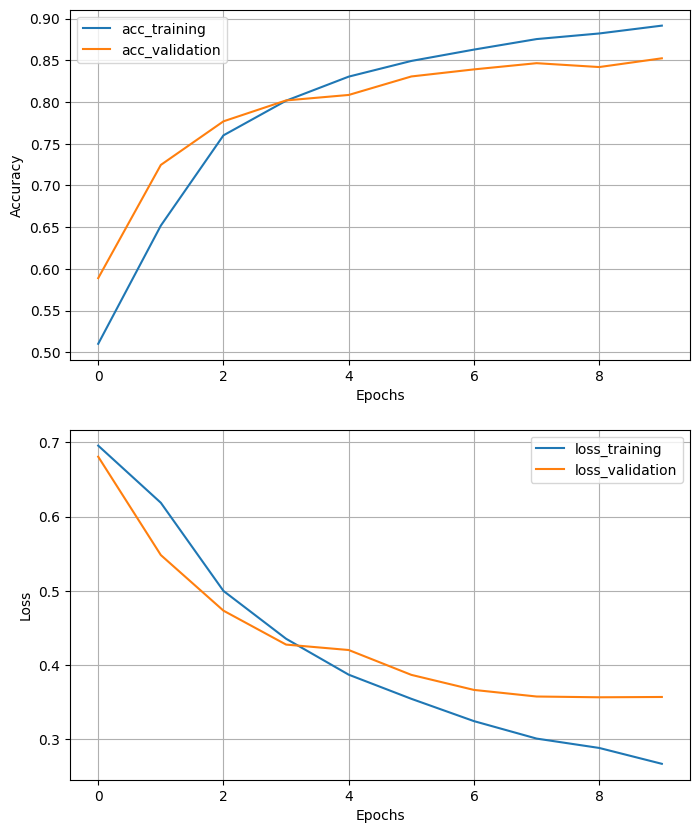

In [50]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

`%ENDCODE`

In [51]:
def test_trns(model, dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (label, text) in enumerate(dataloader_test):
      pre_label = model(text, label)
      loss += criterion(pre_label, label)
      labels_form_pre_label = lambda x: 0. if x < 0.5 else 1.
      pre_label = torch.tensor(list(map(labels_form_pre_label, pre_label))).to(model.device)
      total_acc_test += (pre_label == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")

`%STARTCODE`

In [52]:
gc.collect()
test_trns(transformer, dataloader_test_trns)

Test Loss: 0.36481082 ---------- Test Accuracy: 85.0400%


`%ENDCODE`